In [2]:
import numpy as np
from qiskit import *

# Qiskit Aer

With Qiskit Terra we were able to __create__ quantum circuits. [Qiskit Aer](https://github.com/Qiskit/qiskit-aer) is our package for __simulating__ quantum circuits. Qiskit Aer provides many different backends for doing a simulation. There is also a basic, Python only, implementation called `BasicAer` in Terra that can be used as a drop-in replacement for `Aer` in the examples below.

Note that under the hood, all of Aer's simulators perform simple linear algebra operations with numpy on your __classical computer__. However, these simulators are great for testing stuff under __ideal__ (noise-free) conditions. Aer also provides [noisy simulators](https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html) that mimic a real quantum device with all its different sources of noise. Feel free to check it out later.

### Statevector backend

The most common backend in Qiskit Aer is the `statevector_simulator`. This simulator returns the quantum 
state itself, which is a complex vector of dimensions $2^n$, where $n$ is the number of qubits 
(so be careful using this as it will quickly get too large to run on your machine).

In [3]:
# Import Aer
from qiskit import Aer

In [4]:
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

In [5]:
# Bell state circuit from first notebook
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Now that we have chosen the backend, it's time to compile and run the quantum circuit. In Qiskit we provide the `run` function for this. ``run`` returns a ``job`` object that encapsulates information about the job submitted to the backend.


<div class="alert alert-block alert-info">
<b>Tip:</b> You can view the definition of function parameters directly in Jupyter. Simply place the text cursor on a function and press Shift+Tab.
</div>

In [6]:
# Create a Quantum Program for execution 
job = backend.run(circ)

When you run a program, a job object is made that has the following two useful methods: 
`job.status()` and `job.result()`, which return the status of the job and a result object, respectively.

<div class="alert alert-block alert-info">
<b>Note:</b> Jobs run asynchronously, but when the result method is called, it switches to synchronous and waits for it to finish before moving on to another task.
</div>

In [7]:
result = job.result()

The results object contains the data and Qiskit provides the method 
`result.get_statevector(circ)` to return the state vector for the quantum circuit.

In [8]:
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)

Statevector([0.707+0.j, 0.   +0.j, 0.   +0.j, 0.707+0.j],
            dims=(2, 2))


Qiskit also provides a visualization toolbox to allow you to view these results.

Below, we use the visualization function to plot the real and imaginary components of the state density matrix $\rho$.


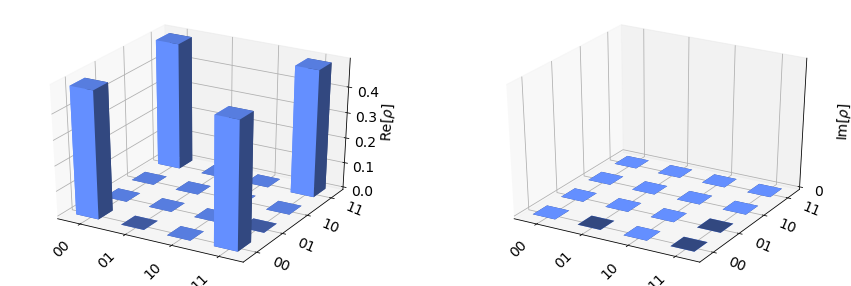

In [9]:
from qiskit.visualization import plot_state_city
plot_state_city(outputstate)

$\color{red}{\text{Exercise 1: Run the GHZ circuit and visualize the final state}}$

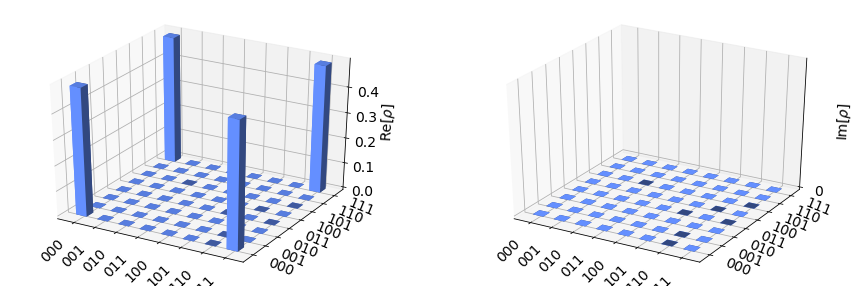

In [10]:
backend = Aer.get_backend('statevector_simulator')
#Your code goes here
circ = QuantumCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.cx(0, 2)

job = backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
plot_state_city(outputstate)

### Unitary backend

Qiskit Aer also includes a `unitary_simulator` that works _provided all the elements in the circuit are unitary operations_. This backend calculates the $2^n \times 2^n$ matrix representing the gates in the quantum circuit. 

In [11]:
# Run the quantum circuit on a unitary simulator backend
backend = Aer.get_backend('unitary_simulator')
job = backend.run(circ)
result = job.result()

# Show the results
print(result.get_unitary(circ, decimals=3))

Operator([[ 0.707+0.j,  0.707-0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.707+0.j, -0.707+0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j,  0.707-0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.707+0.j,
           -0.707+0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.707+0.j,
            0.707-0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j, -0.707+0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.707+0.j,  0.707-0.j],
          [ 0.707+0.j, -0.707+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 

### OpenQASM backend

The simulators above are useful because they provide information about the state output by the ideal circuit and the matrix representation of the circuit. However, a real experiment terminates by _measuring_ each qubit (usually in the computational $|0\rangle, |1\rangle$ basis). Without measurement, we cannot gain information about the state. Measurements cause the quantum system to collapse into classical bits. 

For example, suppose we make independent measurements on each qubit of the two-qubit Bell state

$$|\psi\rangle = (|00\rangle +|11\rangle)/\sqrt{2},$$

and let $xy$ denote the bitstring that results. Recall that, under the qubit labeling used by Qiskit, $x$ would correspond to the outcome on qubit 1, $y$ to the outcome on qubit 0. 

<div class="alert alert-block alert-info">
<b>Note:</b> This representation of the bitstring puts the most significant bit (MSB) on the left, and the least significant bit (LSB) on the right. This is the standard ordering of binary bitstrings. We order the qubits in the same way (qubit representing the MSB has index 0), which is why Qiskit uses a non-standard tensor product order.
</div>

Recall the probability of obtaining outcome $xyz$ is given by

$$\mathrm{Pr}(xy) = |\langle xy | \psi \rangle |^{2}$$

and as such for the Bell state probability of obtaining 00 or 11 are both 1/2.

To simulate a circuit that includes measurement, we need to add measurements to the original circuit above, and use a different Aer backend.

In [12]:
# Create a Quantum Circuit with two qbits and two classical bits
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)

# map the quantum measurement to the classical bits
qc.measure(range(2), range(2)) # first argument tells which qubit to measure; second argument gives the classical bit to store the measurement in
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

This circuit adds a classical register, and two measurements that are used to map the outcome of qubits to the classical bits.

To simulate this circuit, we use the ``qasm_simulator`` in Qiskit Aer. Each run of this circuit will yield either the bitstring 000 or 111. To build up statistics about the distribution of the bitstrings (e.g., to estimate $\mathrm{Pr}(000)$), we need to repeat the circuit many times. The number of times the circuit is repeated can be specified in the ``run`` function, via the ``shots`` keyword.

In [13]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Run the circuit on the qasm simulator.
# We've set the number of measurements of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(qc, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

Once you have a result object, you can access the counts via the function `get_counts(circuit)`. This gives you the _aggregated_ binary outcomes of the circuit you submitted.

In [14]:
counts = result_sim.get_counts(qc)
print(counts)

{'00': 524, '11': 500}


$\color{red}{\text{Exercise 2: Measure a GHZ state and get the output counts}}$

In [15]:
qc = QuantumCircuit(3,3)
#Your code goes here
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure(range(3), range(3))

job_sim = backend_sim.run(qc, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

{'000': 509, '111': 515}


Approximately 50 percent of the time, the output bitstring is 000. Qiskit also provides a function `plot_histogram`, which allows you to view the outcomes. 

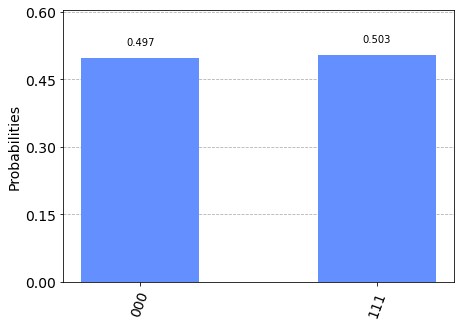

In [16]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

The estimated outcome probabilities $\mathrm{Pr}(000)$ and  $\mathrm{Pr}(111)$ are computed by taking the aggregate counts and dividing by the number of shots (the number of times the circuit was repeated). Try changing the ``shots`` keyword in the ``run`` function and see how the estimated probabilities change.

To summarize, Aer provides different means of simulating a defined circuit. The `qasm_simulator` mimicks a real, ideal quantum device which can only return measurement outcomes (i.e. bitstrings). The `unitary_simulator`/`statevector_simulator` return the unitary matrix/quantum state. However, this information is not easily accessible in an experiment on real hardware. Moreover, the Unitary/Statevector simulators are efficient only on a small number of qubits and quickly blow up due to the exponentially growing Hilbert space dimension (This is why we are building quantum computers in the first place!!).

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.